# Quickstart

This package is meant to get you from chromatogram to quantified peaks as rapidly 
as possible. Below is a brief example of how to go from a raw, off-the-machine 
data set to a list of compounds and their absolute concentrations.   

In [43]:
import hplc.quant
import hplc.io
import importlib
importlib.reload(hplc.quant)
importlib.reload(hplc.io)

<module 'hplc.io' from '/Users/gchure/Dropbox/git/postdoc_projects/hplc-py/hplc/io.py'>

## Loading and viewing chromatograms
Text files containing chromatograms with time and signal information can be intelligently read into a pandas DataFrame using `hplc.io.load_chromatogram()`.

In [44]:
# Load the chromatogram as a dataframe
df = hplc.io.load_chromatogram('data/sample.txt', 
                                 colnames=['R.Time (min)', 'Intensity'])
df.head()

,R.Time (min),Intensity
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


By providing the column names as a dictionary, you can rename the (often annoying)
default column names to something easier to work with, such as "time" and "signal"
as 

In [45]:
# Load chromatogram and rename the columns
df = hplc.io.load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time',
                                                              'Intensity': 'signal'})
df.head()

,time,signal
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


This dataframe can now be loaded passed to the `Chromatogram` class, which 
has a variety of methods for quantification, cropping, and visualization and
more.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

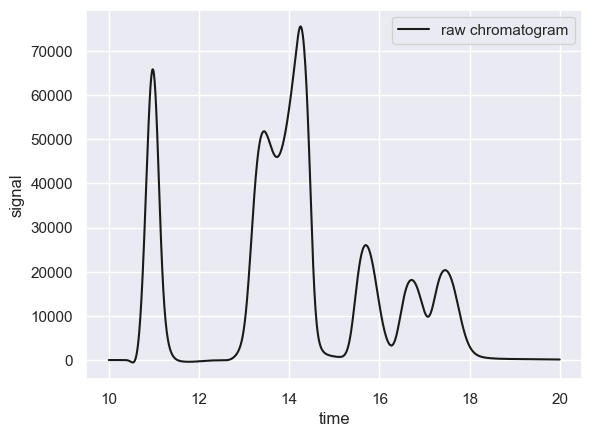

In [46]:
# Instantiate the Chromatogram class with the loaded chromatogram.
chrom = hplc.quant.Chromatogram(df)

# Crop the chromatogram between 10 and 20 minutes.
chrom.crop([10, 20])

# Show the chromatogram
chrom.show()

## 

# Detecting and Quantifying Peaks
The real meat of the package comes in the deconvolution of signal into discrete
peaks and measurement of their properties. Described in more detail in **XXX**,
this typically involves the automated estimation and subtraction of the baseline,
detection of peaks, and fitting of skew-normal distributions to reconstitute the 
signal. Luckily for you, all of this is done in a single method call `Chromatogram.fit_peaks()`

In [47]:
# Automatically detect and fit the peaks 
peaks = chrom.fit_peaks(approx_peak_width=1.5)
peaks.head()

Performing baseline correction: 100%|██████████| 88/88 [00:00<00:00, 2630.39it/s]


Fitting peak windows...: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


,retention_time,scale,skew,amplitude,area,peak_idx
0,10.904346,0.157576,0.677681,23248.374728,2.789805e+06,1
0,13.170591,0.582275,3.835470,42211.177959,5.065341e+06,2
0,14.447608,0.353215,-3.020241,35258.103090,4.230972e+06,3
0,15.531930,0.312260,1.628720,14876.464312,1.785176e+06,4
0,16.522931,0.341967,1.962994,10720.643275,1.286477e+06,5


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

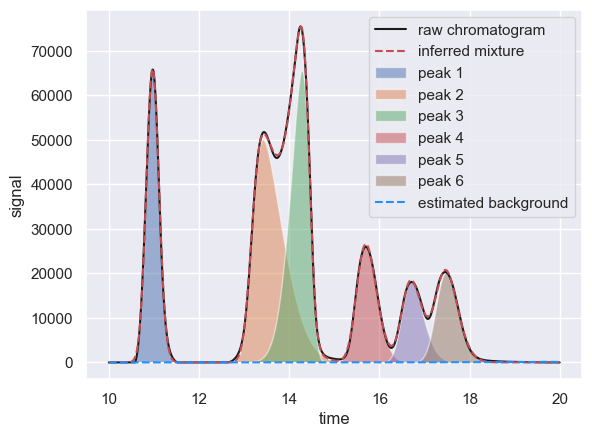

In [48]:
chrom.show()

(10.0, 20.0)

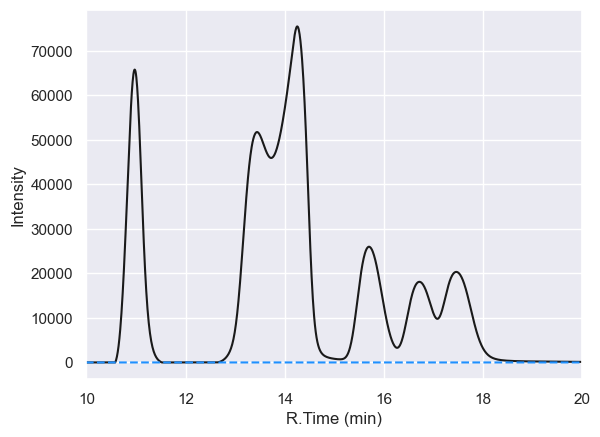

In [14]:
ikfig, ax = chrom.show()
ax.set_xlim(10, 20)

In [15]:
chrom.detect_peaks()

Fitting peak windows...: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


,retention_time,scale,skew,amplitude,area,peak_idx
0,10.904346,0.157576,0.677681,23248.375226,2.789805e+06,1
0,13.170560,0.582716,3.838973,42239.437428,5.068732e+06,2
0,14.447586,0.353081,-3.019459,35236.424407,4.228371e+06,3
0,15.531773,0.312543,1.630870,14888.892959,1.786667e+06,4
0,16.522116,0.344196,1.983761,10768.016016,1.292162e+06,5
0,17.292673,0.343024,1.642864,12421.725863,1.490607e+06,6


Column names can be automatically renamed to your liking by passing `colnames`
to `load_chromatogram()` as a dictionary.

(10.0, 20.0)

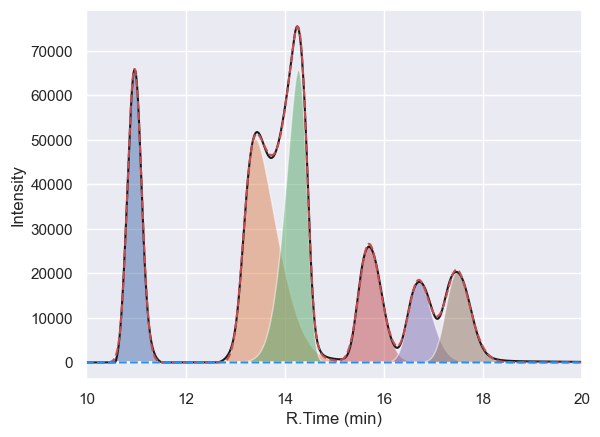

In [16]:
fig, ax = chrom.show()
ax.set_xlim(10, 20)

In [11]:
import numpy as np 
import pandas as pd

def load_chromatogram(fname, colnames=[], delimiter=',', dropna=False):
    R"""
    Parses a file containing a chromatogram and returns it as a Pandas DataFrame.

    Parameters 
    -----------
    fname: `str`
        The path to the file containing the chromatogram. This must be a text
        file (i.e. not `.xslx`!) 
    colnames : `list` or `dict`
        The desired columns present in the file. If provided as a dict, columns will
        be renamed as `key` -> `value`. If not provided, it will be assumed 
        that the chromatogram begins without needing to skip any lines. 
    delimiter : 'str' 
        The delimiter character separating columns in the chromatogram.
    dropna: `bool`
        If True, NaN's will be dropped from the chromatogram.  

    Returns
    -------
    df : `pandas.core.frame.DataFrame`
        The chromatogram loaded as a Pandas DataFrame with the desired columns.
    """
    if type(colnames) != dict:
        _colnames = list(colnames.keys())
    else:
        _colnames = colnames
    skip = 0
    if len(_colnames) != 0:
        with open(fname, 'r') as f:
            _lines = f.readlines()
            halted = False
            for line in _lines:   
                if np.array([nom.lower() in line.lower() for nom in _colnames]).all():
                    halted = True
                    break
                else:
                    skip += 1
            if not halted:
                raise ValueError("Provided column name(s) were not found in file. Check spelling?")

    # Given skips, load in dataframe and rename if necessary
    df = pd.read_csv(fname, skiprows=skip, delimiter=delimiter)
    if type(colnames) == dict:
        df.rename(columns=colnames, inplace=True)
        _colnames = list(colnames.values())
    if dropna:
        df.dropna(inplace=True)

    # Keep only the desired columns.
    df = df[_colnames]
    return df
    

                



In [13]:
load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time_min'})

,time_min
0,0.00000
1,0.00833
2,0.01667
3,0.02500
4,0.03333
...,...
4796,39.96667
4797,39.97500
4798,39.98333
4799,39.99167


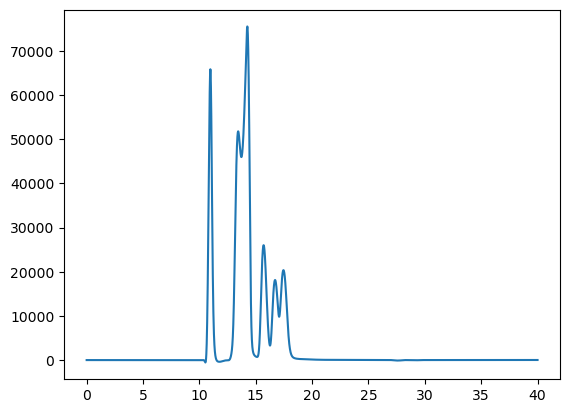

In [47]:
import matplotlib.pyplot as plt 
plt.plot(df['time_min'], df['intensity_mV'])

In [16]:
f = 'Test this line'
names = ['this', 'line', 'Test']
'test' in f.lower()

True

In [18]:
z[:10]

['[Header]\n',
 'Application Name,LabSolutions\n',
 'Version,5.97 SP1\n',
 'Data File Name,C:\\Users\\cremerlab\\Desktop\\Richa\\June 30th 2023 ECOR_yield_Mal_and_Fru_calibration_curves\\June30th 2023_6302023_015_016.lcd\n',
 'Output Date,7/1/2023\n',
 'Output Time,5:23:44 AM\n',
 '\n',
 '[File Information]\n',
 'Type,Data File\n',
 'Generated,7/1/2023 4:43:22 AM\n']

In [ ]:
def load_chromatogram(fname, colnames=[], )